In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Задача

В данном задании вам предлагается решить задачу извлечения аргументов (объектов, аспектов и предикатов) из предложения. Такая модель должна быть обучена на предложениях, где слова или фразы имеют разметку последовательности – каждому слову соответствует его тег.

> **Пример.** Postgres is easier to install and maintain than Oracle.
>
> [Postgres **OBJECT**] is [easier **PREDICATE**] to [install **ASPECT**] and [maintain **ASPECT**] than [Oracle **OBJECT**].

> Сущности могут состоять из нескольких слов: Advil works better for body aches and pains than Motrin.
>
> [Advil **OBJECT**] works [better **PREDICATE**] for [body aches **ASPECT**] and [pains **ASPECT**] than [Motrin **OBJECT**].

Данные состоят из сравнительных предложений (т.е. предложений, содержащих сравнение двух или более объектов). В предложениях содержится следующая информация:

-	*Объекты* – объекты, которые сравниваются
-	*Аспекты* – характеристики, по которым сравниваются объекты
-	*Сказуемое* – слова или фразы, которые реализуют сравнение (обычно сравнительные прилагательные или наречия)

В наборе данных используется схема BIO:

- Первое слово сущности помечается тегом `B-<entity-type>` (начало сущности).
- Второе и последующие слова сущности помечаются тегом `I-<entity-type>` (внутри сущности).
- Слова, которые не являются частью сущности, помечаются тегом `O` (вне сущности).

Поэтому в нашем наборе данных используются следующие метки:
- O
- B-Object
- I-Object
- B-Aspect
- I-Aspect
- B-Predicate
- I-Predicate

**Ваша задача** – присвоить одну из таких меток каждому токену данных путем обучения модели на основе LSTM.


# Data loading

In [3]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long, device=device)

In [4]:
def read_dataset(filename, splitter="\t"):
    data = []
    sentence = []
    tags = []
    with open(filename) as f:
        for line in f:
            if not line.isspace():
                word, tag = line.split(splitter)
                sentence.append(word)
                tags.append(tag.strip())
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
    return data

In [8]:
!gdown 1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y

Downloading...
From: https://drive.google.com/uc?id=1wkfEJCUKF5nbZ6lV6HlRtcEaNkLrLo7y
To: /content/train.tsv
100% 599k/599k [00:00<00:00, 148MB/s]


In [9]:
!gdown 10kS7glt0sLoh6UIn0RtpREW-zcU_zIay

Downloading...
From: https://drive.google.com/uc?id=10kS7glt0sLoh6UIn0RtpREW-zcU_zIay
To: /content/test_no_answer.tsv
100% 43.1k/43.1k [00:00<00:00, 70.1MB/s]


In [10]:
training_data = read_dataset("train.tsv")

In [11]:
training_data[0]

(['also',
  ',',
  'i',
  'have',
  'recently',
  'discovered',
  'advil',
  'liquigels',
  'work',
  'much',
  'better',
  'and',
  'faster',
  'for',
  'a',
  'headache',
  'than',
  'regular',
  'ibuprofen',
  '.'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-Object',
  'O',
  'O',
  'O',
  'B-Predicate',
  'O',
  'B-Predicate',
  'O',
  'O',
  'B-Aspect',
  'O',
  'O',
  'B-Object',
  'O'])

In [12]:
test_data = read_dataset("test_no_answer.tsv", splitter="\n")

In [13]:
test_data[0]

(['meanwhile',
  ',',
  'though',
  'windows',
  '8',
  'is',
  'significantly',
  'at',
  'greater',
  'risk',
  '(',
  '1',
  '.',
  '73',
  'percent',
  ')',
  'compared',
  'to',
  'windows',
  '8',
  '.',
  '1',
  ',',
  'according',
  'to',
  'redmond',
  "'",
  's',
  'report',
  ',',
  'it',
  "'",
  's',
  'still',
  'significantly',
  'safer',
  'than',
  'windows',
  '7',
  ',',
  'windows',
  'xp',
  ',',
  'or',
  'windows',
  'vista',
  '.'],
 ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''])

In [14]:
word_to_ix = {}

# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

for sent, tags in test_data:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index


tag_to_ix = {
    "O": 0,
    "B-Object": 1,
    "I-Object": 2,
    "B-Aspect": 3,
    "I-Aspect": 4,
    "B-Predicate": 5,
    "I-Predicate": 6
}  # Assign each tag with a unique index

idx_to_tag = dict(map(reversed, tag_to_ix.items()))

In [15]:
for X, y in training_data:
    print(X, y)
    break

['also', ',', 'i', 'have', 'recently', 'discovered', 'advil', 'liquigels', 'work', 'much', 'better', 'and', 'faster', 'for', 'a', 'headache', 'than', 'regular', 'ibuprofen', '.'] ['O', 'O', 'O', 'O', 'O', 'O', 'B-Object', 'O', 'O', 'O', 'B-Predicate', 'O', 'B-Predicate', 'O', 'O', 'B-Aspect', 'O', 'O', 'B-Object', 'O']


# Tagger

Опишите архитектуру нейросети. Все необходимые слои описаны в комментариях. В качестве выхода из модели используйте логистический softmax:

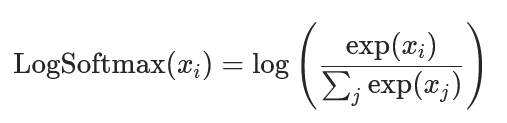

In [47]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        torch.manual_seed(5)
        torch.cuda.manual_seed(5)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        self.hidden_dim = hidden_dim
        # The Embedding layer with size of the dictionary vocab_size
        self.embedding = torch.nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = torch.nn.LSTM(embedding_dim, hidden_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.linear = torch.nn.Linear(hidden_dim, tagset_size)
        self.fc = torch.nn.LogSoftmax(dim=1)

    def forward(self, sentence):
        x_emb = self.embedding(sentence)
        # print(x_emb.shape)
        lstm_out, _ = self.lstm(x_emb)
        # print(lstm_out.shape)
        linear_out = self.linear(lstm_out)
        # print(linear_out.shape)
        # return tag scores as a softmax followed by a logarithm
        tag_scores = self.fc(linear_out)
        # print(tag_scores.shape)
        return tag_scores

# Training

Обучите модель с представленными ниже параметрами.

In [57]:
EMBEDDING_DIM = 32
HIDDEN_DIM = 64

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
model = model.to(device)

loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
# optimizer = optim.Adam(model.parameters(), lr=0.1)

 10%|█         | 1/10 [00:54<08:11, 54.58s/it]

Epoch 1 train loss: 0.859


 20%|██        | 2/10 [01:47<07:11, 53.89s/it]

Epoch 2 train loss: 0.849


 30%|███       | 3/10 [02:41<06:15, 53.62s/it]

Epoch 3 train loss: 0.846


 40%|████      | 4/10 [03:35<05:22, 53.78s/it]

Epoch 4 train loss: 0.843


 50%|█████     | 5/10 [04:28<04:28, 53.61s/it]

Epoch 5 train loss: 0.839


 60%|██████    | 6/10 [05:21<03:33, 53.46s/it]

Epoch 6 train loss: 0.837


 70%|███████   | 7/10 [06:15<02:41, 53.67s/it]

Epoch 7 train loss: 0.836


 80%|████████  | 8/10 [07:09<01:47, 53.54s/it]

Epoch 8 train loss: 0.836


 90%|█████████ | 9/10 [08:02<00:53, 53.42s/it]

Epoch 9 train loss: 0.836


100%|██████████| 10/10 [08:56<00:00, 53.67s/it]

Epoch 10 train loss: 0.836


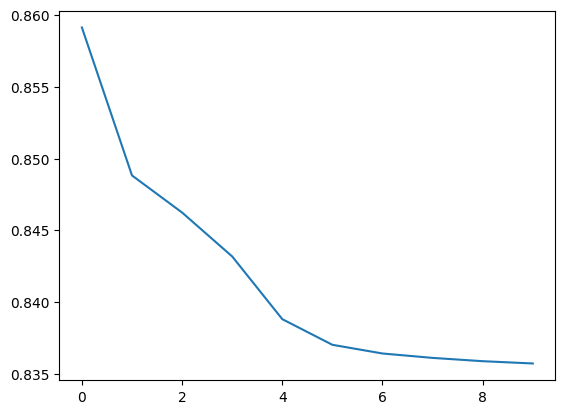

In [58]:
history = []
n_epoch = 10
for epoch in tqdm(range(n_epoch)):  # normally you would NOT do 300 epochs, it is toy data
    train_loss = 0
    for X, y in training_data:
        tensor_X = prepare_sequence(X, word_to_ix)
        tensor_y = prepare_sequence(y, tag_to_ix)

        optimizer.zero_grad()
        predicts = model(tensor_X)
        loss = loss_function(predicts, tensor_y)
        loss.backward()
        optimizer.step()
        train_loss += np.sum(loss.detach().cpu().numpy())

    epoch_loss = train_loss/len(training_data)
    history.append(epoch_loss)
    print(f"Epoch {epoch + 1} train loss: {epoch_loss:.3f}")

plt.plot(np.arange(n_epoch), history)

# Inference
Предскажите метки для слов из первого предложения.

In [59]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[0][0], word_to_ix)
    tag_scores = model(sentence_to_predict)
    print(test_data[0][0])
    print([idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)])

['meanwhile', ',', 'though', 'windows', '8', 'is', 'significantly', 'at', 'greater', 'risk', '(', '1', '.', '73', 'percent', ')', 'compared', 'to', 'windows', '8', '.', '1', ',', 'according', 'to', 'redmond', "'", 's', 'report', ',', 'it', "'", 's', 'still', 'significantly', 'safer', 'than', 'windows', '7', ',', 'windows', 'xp', ',', 'or', 'windows', 'vista', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Предскажите метки для слов из десятого предложения.

In [60]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[11][0], word_to_ix)
    tag_scores = model(sentence_to_predict)
    print(test_data[11][0])
    print([idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)])

['actually', ',', 'from', 'things', 'i', "'", 've', 'seen', ',', 'windows', '8', 'requires', 'less', 'of', 'the', 'hardware', 'than', 'windows', '7', '(', 'runs', 'faster', '/', 'leaner', 'than', 'windows', '7', 'on', 'the', 'same', 'hardware', ')', 'and', 'windows', '7', 'runs', 'as', 'good', 'as', '(', 'or', 'better', 'than', ')', 'windows', 'xp', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Предскажите метки для слов из сотого предложения.

In [61]:
with torch.no_grad():
    sentence_to_predict = prepare_sequence(test_data[101][0], word_to_ix)
    tag_scores = model(sentence_to_predict)
    print(test_data[101][0])
    print([idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)])

['plus', 'on', 'the', 'desktop', '/', 'laptop', '/', 'tablet', 'i', 'can', 'type', 'a', 'lot', 'faster', 'than', 'using', 'my', 'thumbs', 'on', 'my', 'phone', 'which', 'i', 'love', '!']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Сохраните результаты предсказания на тестовом наборе (`test_data`) в файл, запустив код ниже.

In [62]:
with open("out_test.tsv", "w") as w:
    with torch.no_grad():
        for sentence in tqdm(test_data):
            inputs = prepare_sequence(sentence[0], word_to_ix)
            tag_scores = model(inputs)
            tags = [idx_to_tag[int(i)] for i in tag_scores.argmax(dim=-1)]
            for i, y in zip(sentence[0], tags):
                w.write(f"{i}\t{y}\n")
            w.write("\n")

100%|██████████| 283/283 [00:01<00:00, 207.26it/s]


Файл `test.tsv` содержит разметку тестовых данных. Сравните файлы построчно, запустив код ниже. Сколько суммарно меток было предсказано верно (то есть сколько строк совпало)?

In [63]:
!gdown 1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd

Downloading...
From: https://drive.google.com/uc?id=1mUtlDtb7naXDi1U8x73UdyncnHv1BOjd
To: /content/test.tsv
100% 81.1k/81.1k [00:00<00:00, 114MB/s]


In [64]:
points = 0
with open("test.tsv", "r") as f_eval, open("out_test.tsv", "r") as f:
  for line_eval, line in zip(f_eval.readlines(), f.readlines()):
    if line_eval == line: points += 1
print(points)

7017
